In [1]:
import numpy as np
import sys

sys.path.append('/home/aseem/python_modules/cosmology/')
from universe import Cosmology

from time import time
import gc
import copy

import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib as mpl
import matplotlib.colors as pltcol

In [2]:
import numpy as np
import sys

sys.path.append('/home/aseem/python_modules/cosmology/')
from universe import Cosmology

from time import time
import gc

import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib as mpl
import matplotlib.colors as pltcol

In [3]:
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.right'] = True
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['legend.fontsize'] = 14 # 14
mpl.rcParams['legend.labelspacing'] = 0.25
FS = 18
FS2 = 15
FS3 = 13
FSL = 22

mpl.rcParams['xtick.major.size'] = 6
mpl.rcParams['xtick.minor.size'] = 3
mpl.rcParams['ytick.major.size'] = 6
mpl.rcParams['ytick.minor.size'] = 3

#mpl.rcParams.keys()

# Cosmological Parameter Variations
### Impact of varying Sahyadri cosmological parameters on non-linear cosmological statistics
Statistics explored <span style="color:red"> (all at $z=0$)</span>:
1. Non-linear matter power spectrum (HALOFIT)
2. Halo mass function (Tinker+ 2008)
3. Linear halo bias (Tinker+ 2010)

## Fiducial cosmology

In [4]:
# to control plots
Lbox = 200.0
Npart = 2048

In [5]:
Om = 0.3137721
Ob = 0.0493017
Ok = 0.0
h = 0.6736
ns = 0.9649
As = 2.098903e-9
w0 = -1.0

Pklin = 'class'

start_time = time()
co_fid = Cosmology(Om=Om,Ob=Ob,Ok=Ok,hubble=h,ns=ns,As=As,wDE0=w0,Pklin=Pklin)
# Dnl_fid = co_fid.nonlinearpower(model=1)
# kvals = co_fid.ktab_lin*co_fid.hubble # values in Mpc^-1

mtab = np.logspace(10,15.5,30) # Msun/h
# mf_fid,b1_fid = co_fid.massfuncbiasTinker(mtab)
mvals = mtab/co_fid.hubble # values in Msun

co_fid.time_this(start_time)

... initialising Cosmology()
... ... detected As normalisation, will override sig8.
... ... calculating linear power spectrum at present epoch
... ... cosmology (Om,OLam,Ob,h,sig8,ns) = (0.3138,0.6861,0.04930,0.6736,0.8150,0.9649)
... ... using CLASS
[....................] 100% done
... using As normalisation
... ln(1e10*As),sig8 = 3.044,0.823
... done
0 min 3.53 seconds



In [15]:
def vary_and_plot(param,var,cf,mvals,Lbox=200,Npart=2048):
    """ Vary parameter by specified amount and factor 2 of this amount, up and down, 
        and plot results for nonlinear matter power spectrum, halo mass function and linear halo bias.
        -- param: string, one of ['Om','Ob','Ok','h','As','ns','w0']
        -- var: required variation
        -- cf: instance of Cosmology with fiducial parameters
        -- mvals: array of mass values in Msun
        -- Lbox (Mpc/h_fid),Npart: to control plot ranges
    """
    if not isinstance(cf,Cosmology):
        raise Exception('cf must be valid instance of Cosmology with fiducial parameters')

    # label dictionary for plots
    ld = {'Om':"\\Omega_{\\rm m}",'Ob':"\\Omega_{\\rm b}",'Ok':"\\Omega_{\\rm k}",
          'h':"h",'ns':"n_{{\\rm s}}",'As':"A_{{\\rm s}}",'w0':"w_{{0}}"}
    
    pd_p = {'Om':cf.Om,'Ob':cf.Ob,'Ok':cf.Ok,'h':cf.hubble,'ns':cf.ns,'As':cf.As,'w0':cf.wDE0}
    pd_m = copy.deepcopy(pd_p)
    pd_pp = copy.deepcopy(pd_p)
    pd_mm = copy.deepcopy(pd_p)

    if param not in pd_p.keys():
        raise ValueError('param must be one of ['+','.join([key for key in pd_p.keys()])+']')
    
    pd_p[param] += var
    pd_pp[param] += 2*var
    pd_m[param] -= var
    pd_mm[param] -= 2*var
        
    co_p = Cosmology(Om=pd_p['Om'],Ob=pd_p['Ob'],Ok=pd_p['Ok'],hubble=pd_p['h'],
                     ns=pd_p['ns'],As=pd_p['As'],wDE0=pd_p['w0'],Pklin=cf.Pklin)
    co_pp = Cosmology(Om=pd_pp['Om'],Ob=pd_pp['Ob'],Ok=pd_pp['Ok'],hubble=pd_pp['h'],
                      ns=pd_pp['ns'],As=pd_pp['As'],wDE0=pd_pp['w0'],Pklin=cf.Pklin)
    co_m = Cosmology(Om=pd_m['Om'],Ob=pd_m['Ob'],Ok=pd_m['Ok'],hubble=pd_m['h'],
                     ns=pd_m['ns'],As=pd_m['As'],wDE0=pd_m['w0'],Pklin=cf.Pklin)
    co_mm = Cosmology(Om=pd_mm['Om'],Ob=pd_mm['Ob'],Ok=pd_mm['Ok'],hubble=pd_mm['h'],
                      ns=pd_mm['ns'],As=pd_mm['As'],wDE0=pd_mm['w0'],Pklin=cf.Pklin)

    start_time = time()
    print('Fiducial params...')
    print('... power spectrum')
    Dnl_fid = cf.nonlinearpower(model=1)
    kvals = cf.ktab_lin*cf.hubble # values in Mpc^-1
    print('... mass function and bias')
    mf_fid,b1_fid = co_fid.massfuncbiasTinker(mvals*cf.hubble)
    
    print('Variations...')
    print('... power spectrum')
    Dnl_p = co_p.nonlinearpower(model=1)
    Dnl_pp = co_pp.nonlinearpower(model=1)
    Dnl_m = co_m.nonlinearpower(model=1)
    Dnl_mm = co_mm.nonlinearpower(model=1)

    if param == 'h':
        # need interpolation since code internally uses h/Mpc units for k values
        print('... ... interpolating for hubble variation')
        Dnl_p = np.exp(np.interp(np.log(kvals),np.log(co_p.ktab_lin*co_p.hubble),np.log(Dnl_p)))
        Dnl_pp = np.exp(np.interp(np.log(kvals),np.log(co_pp.ktab_lin*co_pp.hubble),np.log(Dnl_pp)))
        Dnl_m = np.exp(np.interp(np.log(kvals),np.log(co_m.ktab_lin*co_m.hubble),np.log(Dnl_m)))
        Dnl_mm = np.exp(np.interp(np.log(kvals),np.log(co_m.ktab_lin*co_mm.hubble),np.log(Dnl_mm)))
    
    print('... mass function and bias')
    # for mf and bias, explicitly evaluate at correct values of Msun/h
    mf_p,b1_p = co_p.massfuncbiasTinker(mvals*co_p.hubble)
    mf_pp,b1_pp = co_pp.massfuncbiasTinker(mvals*co_pp.hubble)
    mf_m,b1_m = co_m.massfuncbiasTinker(mvals*co_m.hubble)
    mf_mm,b1_mm = co_mm.massfuncbiasTinker(mvals*co_mm.hubble)
    
    cf.time_this(start_time)

    print('Plotting...')
    FSIZE = 5
    fig = plt.figure(figsize=(3*FSIZE,FSIZE))
    gs = gridspec.GridSpec(1,3,width_ratios=[1,1,1],wspace=0.05)
    Ymin,Ymax = -0.15,0.15
    ########################################
    # pow spec ratio
    ax = plt.subplot(gs[0])
    ax.set_xscale('log')
    Xmin = 2*np.pi/Lbox/2*cf.hubble
    Xmax = np.pi*Npart/Lbox*2*cf.hubble
    ax.set_xlim(Xmin,Xmax)
    ax.set_ylim(Ymin,Ymax)
    ax.set_xlabel("$k\\,({\\rm Mpc}^{{-1}})$")
    ax.set_ylabel('variation / fiducial - 1')
    
    ax.plot(kvals,Dnl_pp/Dnl_fid-1,'r--',label='$(++)$')
    ax.plot(kvals,Dnl_p/Dnl_fid-1,'r-',label='$(+)$')
    ax.plot(kvals,Dnl_m/Dnl_fid-1,'b-',label='$(-)$')
    ax.plot(kvals,Dnl_mm/Dnl_fid-1,'b--',label='$(--)$')
    
    var_text = '$'+ld[param]+'$ variation'
    ax.text(2*Xmin,0.1,var_text,fontsize=FS2)
    ax.text(np.sqrt(Xmin*Xmax),-0.125,'nonlinear $P_{{\\rm mm}}(k)$',fontsize=FS2)
    ax.axhline(0.0,c='k',ls='--',lw=1)
    ax.axhline(0.05,c='k',ls=':',lw=0.5)
    ax.axhline(-0.05,c='k',ls=':',lw=0.5)
    ax.minorticks_on()
    ########################################
    
    ########################################
    # mass func ratio
    ax = plt.subplot(gs[1])
    ax.set_xscale('log')
    Xmin = mvals[0]/1.5
    Xmax = mvals[-1]*1.5
    ax.set_xlim(Xmin,Xmax)
    ax.set_ylim(Ymin,Ymax)
    ax.set_xlabel("$m\\,(M_{{\\odot}})$")
    ax.set_yticklabels('')
    
    ax.plot(mvals,mf_pp/mf_fid-1,'r--',label='$(++)$')
    ax.plot(mvals,mf_p/mf_fid-1,'r-',label='$(+)$')
    ax.plot(mvals,mf_m/mf_fid-1,'b-',label='$(-)$')
    ax.plot(mvals,mf_mm/mf_fid-1,'b--',label='$(--)$')
    
    ax.text(3*mvals[0],-0.125,'mass function',fontsize=FS2)
    ax.axhline(0.0,c='k',ls='--',lw=1)
    ax.axhline(0.05,c='k',ls=':',lw=0.5)
    ax.axhline(-0.05,c='k',ls=':',lw=0.5)
    ax.legend()
    ax.minorticks_on()
    ########################################
    
    ########################################
    # bias ratio
    ax = plt.subplot(gs[2])
    ax.set_xscale('log')
    Xmin = mvals[0]/1.5
    Xmax = mvals[-1]*1.5
    ax.set_xlim(Xmin,Xmax)
    ax.set_ylim(Ymin,Ymax)
    ax.set_xlabel("$m\\,(M_{{\\odot}})$")
    ax.set_yticklabels('')
    
    ax.plot(mvals,b1_pp/b1_fid-1,'r--',label='$(++)$')
    ax.plot(mvals,b1_p/b1_fid-1,'r-',label='$(+)$')
    ax.plot(mvals,b1_m/b1_fid-1,'b-',label='$(-)$')
    ax.plot(mvals,b1_mm/b1_fid-1,'b--',label='$(--)$')

    if param in ['Ok','w0']:
        ax.text(3*mvals[0],0.1,'EXTRAPOLATION',color='crimson',fontsize=FS3,fontweight='bold')
    ax.text(3*mvals[0],-0.125,'linear bias',fontsize=FS2)
    ax.axhline(0.0,c='k',ls='--',lw=1)
    ax.axhline(0.05,c='k',ls=':',lw=0.5)
    ax.axhline(-0.05,c='k',ls=':',lw=0.5)
    ax.minorticks_on()
    
    plt.show()

## $\Omega_{\rm m} \pm 2\%$

... initialising Cosmology()
... ... detected As normalisation, will override sig8.
... ... calculating linear power spectrum at present epoch
... ... cosmology (Om,OLam,Ob,h,sig8,ns) = (0.3200,0.6799,0.04930,0.6736,0.8150,0.9649)
... ... using CLASS
[....................] 100% done
... using As normalisation
... ln(1e10*As),sig8 = 3.044,0.835
... done
... initialising Cosmology()
... ... detected As normalisation, will override sig8.
... ... calculating linear power spectrum at present epoch
... ... cosmology (Om,OLam,Ob,h,sig8,ns) = (0.3263,0.6736,0.04930,0.6736,0.8150,0.9649)
... ... using CLASS
[....................] 100% done
... using As normalisation
... ln(1e10*As),sig8 = 3.044,0.847
... done
... initialising Cosmology()
... ... detected As normalisation, will override sig8.
... ... calculating linear power spectrum at present epoch
... ... cosmology (Om,OLam,Ob,h,sig8,ns) = (0.3075,0.6924,0.04930,0.6736,0.8150,0.9649)
... ... using CLASS
[....................] 100% done
... us

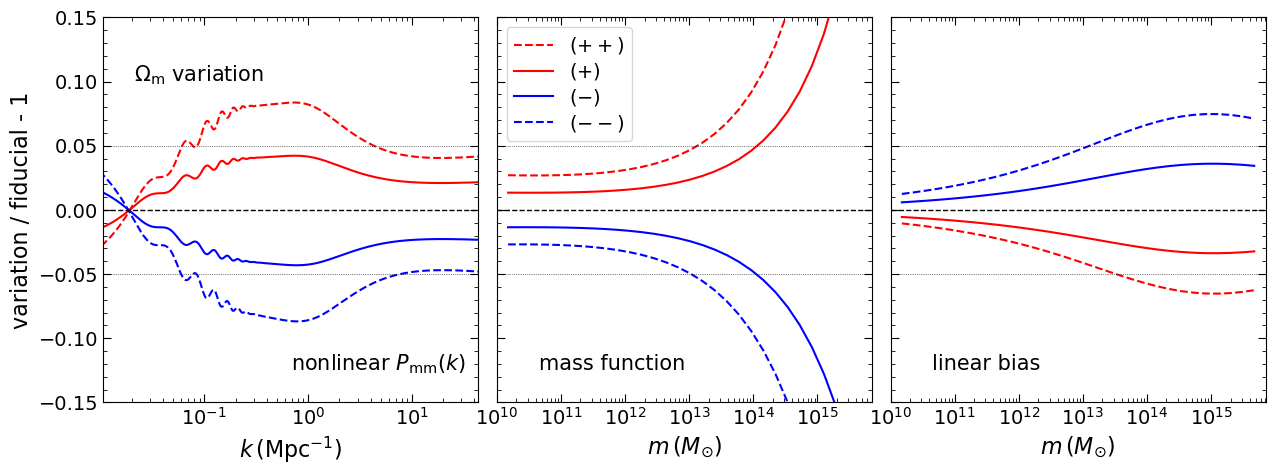

In [7]:
vary_and_plot('Om',0.02*co_fid.Om,co_fid,mvals)

## $\Omega_{\rm b} \pm 2\%$

... initialising Cosmology()
... ... detected As normalisation, will override sig8.
... ... calculating linear power spectrum at present epoch
... ... cosmology (Om,OLam,Ob,h,sig8,ns) = (0.3138,0.6861,0.05029,0.6736,0.8150,0.9649)
... ... using CLASS
[....................] 100% done
... using As normalisation
... ln(1e10*As),sig8 = 3.044,0.818
... done
... initialising Cosmology()
... ... detected As normalisation, will override sig8.
... ... calculating linear power spectrum at present epoch
... ... cosmology (Om,OLam,Ob,h,sig8,ns) = (0.3138,0.6861,0.05127,0.6736,0.8150,0.9649)
... ... using CLASS
[....................] 100% done
... using As normalisation
... ln(1e10*As),sig8 = 3.044,0.813
... done
... initialising Cosmology()
... ... detected As normalisation, will override sig8.
... ... calculating linear power spectrum at present epoch
... ... cosmology (Om,OLam,Ob,h,sig8,ns) = (0.3138,0.6861,0.04832,0.6736,0.8150,0.9649)
... ... using CLASS
[....................] 100% done
... us

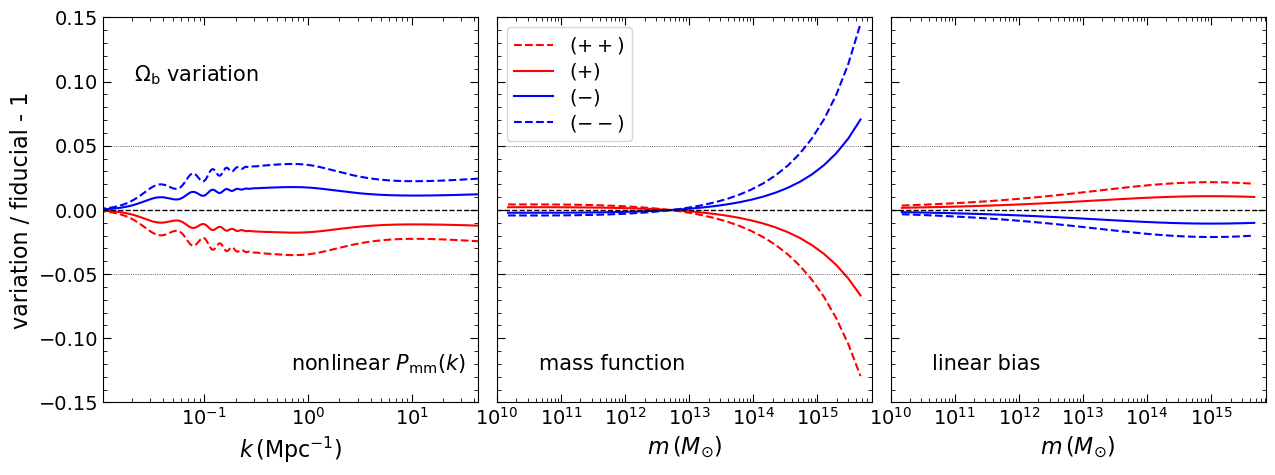

In [8]:
vary_and_plot('Ob',0.02*co_fid.Ob,co_fid,mvals)

## $n_{\rm s} \pm 2\%$

... initialising Cosmology()
... ... detected As normalisation, will override sig8.
... ... calculating linear power spectrum at present epoch
... ... cosmology (Om,OLam,Ob,h,sig8,ns) = (0.3138,0.6861,0.04930,0.6736,0.8150,0.9842)
... ... using CLASS
[....................] 100% done
... using As normalisation
... ln(1e10*As),sig8 = 3.044,0.829
... done
... initialising Cosmology()
... ... detected As normalisation, will override sig8.
... ... calculating linear power spectrum at present epoch
... ... cosmology (Om,OLam,Ob,h,sig8,ns) = (0.3138,0.6861,0.04930,0.6736,0.8150,1.0035)
... ... using CLASS
[....................] 100% done
... using As normalisation
... ln(1e10*As),sig8 = 3.044,0.835
... done
... initialising Cosmology()
... ... detected As normalisation, will override sig8.
... ... calculating linear power spectrum at present epoch
... ... cosmology (Om,OLam,Ob,h,sig8,ns) = (0.3138,0.6861,0.04930,0.6736,0.8150,0.9456)
... ... using CLASS
[....................] 100% done
... us

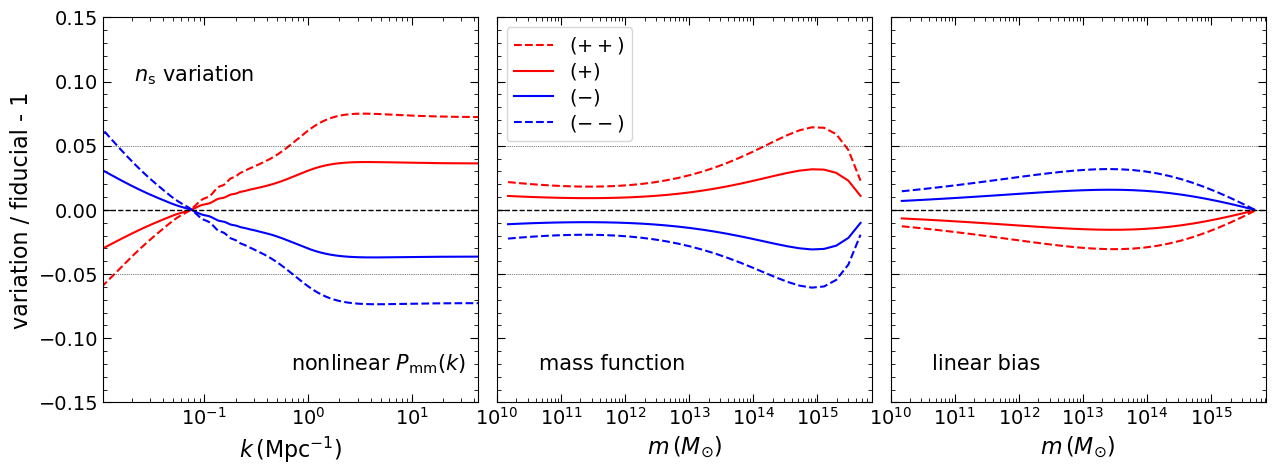

In [9]:
vary_and_plot('ns',0.02*co_fid.ns,co_fid,mvals)

## $A_{\rm s} \pm 2\%$

... initialising Cosmology()
... ... detected As normalisation, will override sig8.
... ... calculating linear power spectrum at present epoch
... ... cosmology (Om,OLam,Ob,h,sig8,ns) = (0.3138,0.6861,0.04930,0.6736,0.8150,0.9649)
... ... using CLASS
[....................] 100% done
... using As normalisation
... ln(1e10*As),sig8 = 3.064,0.831
... done
... initialising Cosmology()
... ... detected As normalisation, will override sig8.
... ... calculating linear power spectrum at present epoch
... ... cosmology (Om,OLam,Ob,h,sig8,ns) = (0.3138,0.6861,0.04930,0.6736,0.8150,0.9649)
... ... using CLASS
[....................] 100% done
... using As normalisation
... ln(1e10*As),sig8 = 3.083,0.839
... done
... initialising Cosmology()
... ... detected As normalisation, will override sig8.
... ... calculating linear power spectrum at present epoch
... ... cosmology (Om,OLam,Ob,h,sig8,ns) = (0.3138,0.6861,0.04930,0.6736,0.8150,0.9649)
... ... using CLASS
[....................] 100% done
... us

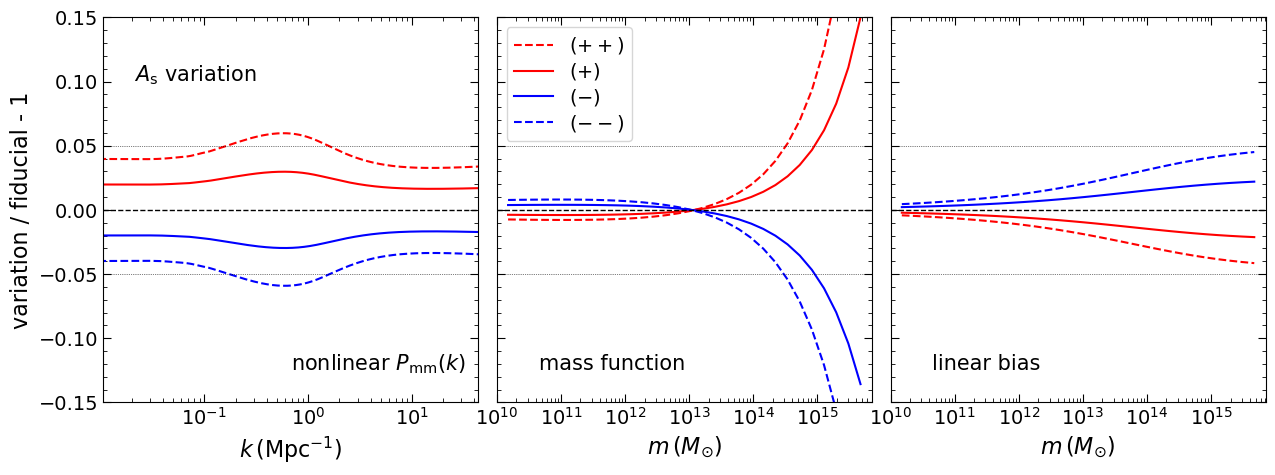

In [10]:
vary_and_plot('As',0.02*co_fid.As,co_fid,mvals)

## $h \pm 2\%$

... initialising Cosmology()
... ... detected As normalisation, will override sig8.
... ... calculating linear power spectrum at present epoch
... ... cosmology (Om,OLam,Ob,h,sig8,ns) = (0.3138,0.6861,0.04930,0.6871,0.8150,0.9649)
... ... using CLASS
[....................] 100% done
... using As normalisation
... ln(1e10*As),sig8 = 3.044,0.841
... done
... initialising Cosmology()
... ... detected As normalisation, will override sig8.
... ... calculating linear power spectrum at present epoch
... ... cosmology (Om,OLam,Ob,h,sig8,ns) = (0.3138,0.6861,0.04930,0.7005,0.8150,0.9649)
... ... using CLASS
[....................] 100% done
... using As normalisation
... ln(1e10*As),sig8 = 3.044,0.859
... done
... initialising Cosmology()
... ... detected As normalisation, will override sig8.
... ... calculating linear power spectrum at present epoch
... ... cosmology (Om,OLam,Ob,h,sig8,ns) = (0.3138,0.6861,0.04930,0.6601,0.8150,0.9649)
... ... using CLASS
[....................] 100% done
... us

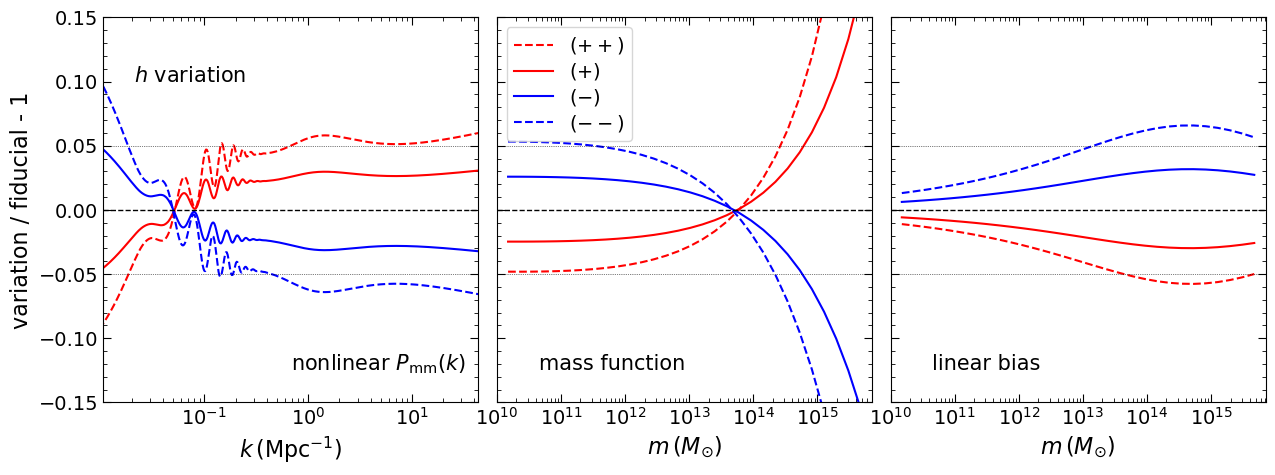

In [12]:
vary_and_plot('h',0.02*co_fid.hubble,co_fid,mvals)

## $\Omega_{\rm k} \pm 0.01$

... initialising Cosmology()
... ... detected As normalisation, will override sig8.
... ... calculating linear power spectrum at present epoch
... ... cosmology (Om,OLam,Ob,h,sig8,ns) = (0.3138,0.6761,0.04930,0.6736,0.8150,0.9649)
... ... using CLASS
[....................] 100% done
... using As normalisation
... ln(1e10*As),sig8 = 3.044,0.815
... done
... initialising Cosmology()
... ... detected As normalisation, will override sig8.
... ... calculating linear power spectrum at present epoch
... ... cosmology (Om,OLam,Ob,h,sig8,ns) = (0.3138,0.6661,0.04930,0.6736,0.8150,0.9649)
... ... using CLASS
[....................] 100% done
... using As normalisation
... ln(1e10*As),sig8 = 3.044,0.807
... done
... initialising Cosmology()
... ... detected As normalisation, will override sig8.
... ... calculating linear power spectrum at present epoch
... ... cosmology (Om,OLam,Ob,h,sig8,ns) = (0.3138,0.6961,0.04930,0.6736,0.8150,0.9649)
... ... using CLASS
[....................] 100% done
... us

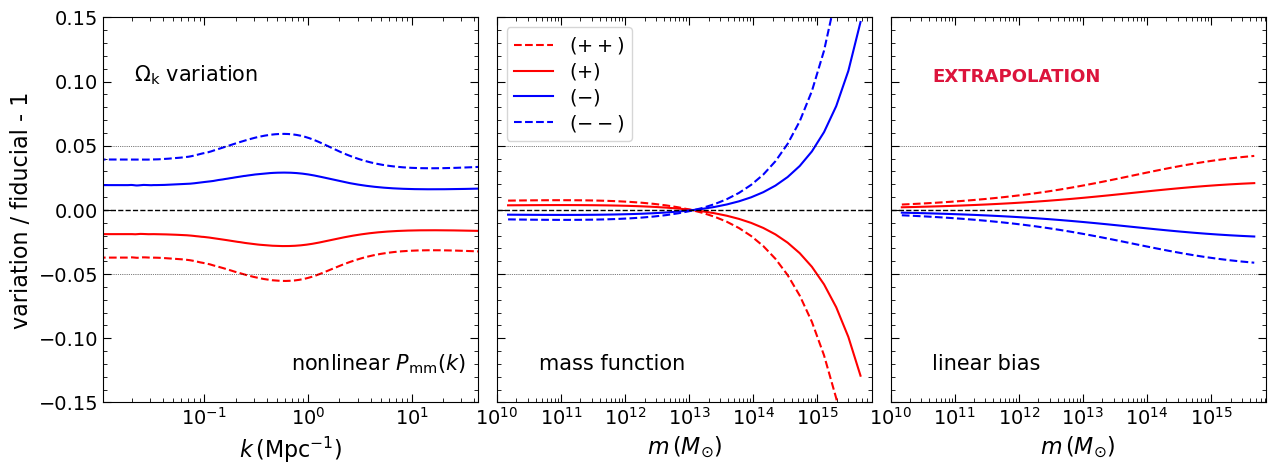

In [16]:
vary_and_plot('Ok',0.01,co_fid,mvals)

## $w_{0} \pm 2\%$ 
### <span style="color:red"> *not sure about growth factor* </span>.

... initialising Cosmology()
... ... detected As normalisation, will override sig8.
... ... calculating linear power spectrum at present epoch
... ... cosmology (Om,OLam,Ob,h,sig8,ns) = (0.3138,0.6861,0.04930,0.6736,0.8150,0.9649)
... ... using CLASS
... ... ... dark energy EoS w0 = -0.980
[....................] 100% done
... using As normalisation
... ln(1e10*As),sig8 = 3.044,0.819
... done
... initialising Cosmology()
... ... detected As normalisation, will override sig8.
... ... calculating linear power spectrum at present epoch
... ... cosmology (Om,OLam,Ob,h,sig8,ns) = (0.3138,0.6861,0.04930,0.6736,0.8150,0.9649)
... ... using CLASS
... ... ... dark energy EoS w0 = -0.960
[....................] 100% done
... using As normalisation
... ln(1e10*As),sig8 = 3.044,0.814
... done
... initialising Cosmology()
... ... detected As normalisation, will override sig8.
... ... calculating linear power spectrum at present epoch
... ... cosmology (Om,OLam,Ob,h,sig8,ns) = (0.3138,0.6861,0.04930,0

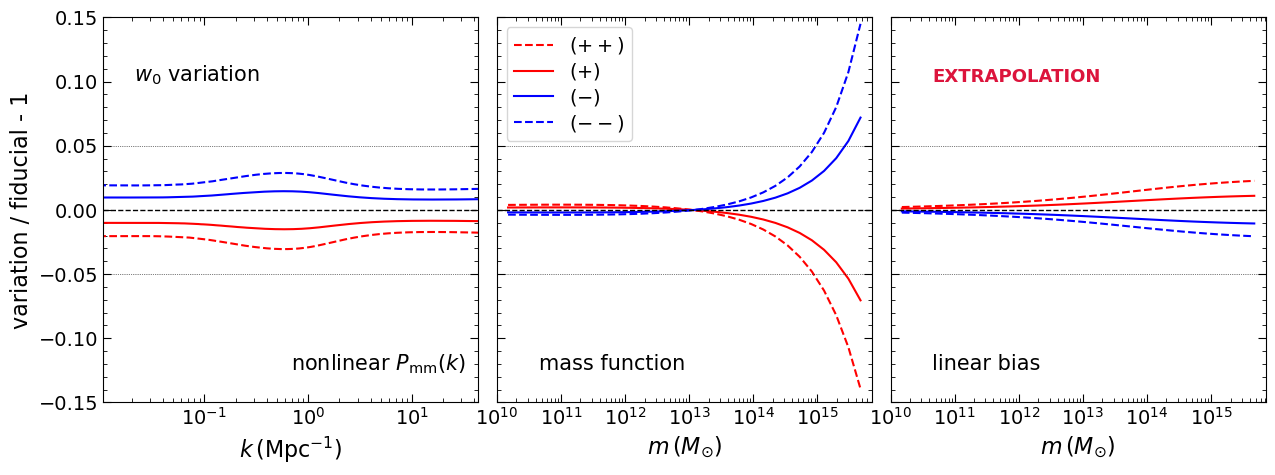

In [17]:
vary_and_plot('w0',0.02*np.fabs(co_fid.wDE0),co_fid,mvals)